# POPPY Simulation: MagAO-X version 9.5 (No aberrations)
## Notes: 
- This file has no aberrations present on the optical surfaces.
- This is version 11.1 of the MagAO-X Zemax file. PDR was at version 7.2.
- This notebook focuses on the F/# focal plane generation to see if any distance corrections are needed.

In [3]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm 
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope and MagAO-X are pulled from Oli Durney's Zemax file, version 9.5. All MagAO-X elements (after F/11 focal plane) have their distances pulled from the Zemax file's Merit Function Editor (using RAG command).

### Optical elements not implemented currently:
- ADC1
- ADC2
- 9mm Lyot stop

### To-do Tasks:
- Determine F/# focal plane correction distances.

In [4]:
# note: u.m is in meters
testWavelength = 656e-9 * u.m # H-alpha
samp = 256  # original version at 512
oversamp = 0.125 # 4x; original version at 3x but I want this to go FAST 

# physical radius values
M1_radius = 3.25 * u.m # This is the correct value to use.
M2_radius = 0.6695 * u.m # This is the correct value to use.
M3_radius = 0.439879 * u.m # Using largest value from various Zemax files
oap_radius = 0.0254 * u.m # 2 inch diameter OAP
flat_radius = 0.025 * u.m # 50mm diameter
dm_radius = 0.025 * u.m # 50mm diameter currently, subject to change if need to be larger

# focal lengths
fl_M1 = 8.128 * u.m
fl_ratio_M2 = 1.07
fl_M2 = 1.43273 * u.m # This is the correct value to use. Calculated from M2_diam * fl_ratio_M2

# Focal lengths of OAPs
fl_oap0 = 0.14355 * u.m
fl_oap1 = 0.21088 * u.m
fl_oap2 = 0.30380 * u.m
fl_oap3 = 1.07160 * u.m
fl_oap4 = 0.51300 * u.m
fl_oap5 = 0.62100 * u.m
fl_oap6 = 0.62100 * u.m
fl_oap7 = 0.62100 * u.m

# propagation distances based on Zemax
# All values before F/11 is not present in Zemax MFE nor solo Magellan Zemax file, so going by distances listed.
d_m1_m2 = 9.72205 * u.m
d_m2_m3 = 9.02279 * u.m
d_m3_wfsdichroic = 4.849516 * u.m
d_wfsdichroic_peri1 = 0.040 * u.m
d_peri1_k1 = 0.020 * u.m
d_k1_k2 = 0.025 * u.m
d_k2_k3 = 0.025 * u.m
d_k3_f11fp = 0.020 * u.m

# Inputted from Zemax MFE, all RAG values
d_f11fp_peri2 = 0.033204 * u.m
d_peri2_oap0 = 0.110497 * u.m 
d_oap0_woofer = 0.144693 * u.m
d_woofer_oap1 = 0.210726 * u.m
d_oap1_fold1 = 0.069174 * u.m
d_fold1_f16fp = 0.141562 * u.m
d_f16fp_oap2 = 0.303808 * u.m
d_oap2_tweeter = 0.303808 * u.m
d_tweeter_oap3 = 1.071599 * u.m # adds through front and back ADC
d_oap3_flat4 = 0.412515 *u.m
d_flat4_flat5 = 0.5737 * u.m
d_flat5_f57fp = 0.64034 * u.m
d_f57fp_oap4 = 0.513026 * u.m
d_oap4_flat6 = 0.231649 * u.m
d_flat6_vapp = 0.281359 * u.m
d_vapp_oap5 = 0.620944 * u.m
d_oap5_fold2 = 0.471013 * u.m
d_fold2_f69fp = 0.150008 * u.m
d_f69fp_oap6 = 0.620969 * u.m
d_oap6_lyot = 0.621031 * u.m
d_lyot_fold3 = 0.231596 * u.m
d_fold3_oap7 = 0.389425 * u.m
d_oap7_fold4 = 0.401103 * u.m
d_fold4_f69sci = 0.219859 * u.m

# Primary and Secondary mirrors
M1 = poppy.QuadraticLens(fl_M1, name='M-1')
M2 = poppy.QuadraticLens(fl_M2, name='M-2')

# OAP mirrors
OAP0 = poppy.QuadraticLens(fl_oap0, name='OAP-0')
OAP1 = poppy.QuadraticLens(fl_oap1, name='OAP-1')
OAP2 = poppy.QuadraticLens(fl_oap2, name='OAP-2')
OAP3 = poppy.QuadraticLens(fl_oap3, name='OAP-3')
OAP4 = poppy.QuadraticLens(fl_oap4, name='OAP-4')
OAP5 = poppy.QuadraticLens(fl_oap5, name='OAP-5')
OAP6 = poppy.QuadraticLens(fl_oap6, name='OAP-6')
OAP7 = poppy.QuadraticLens(fl_oap7, name='OAP-7')

# Saved F/# correction values, calculated and copied from a previous run.
f11_delta = 0.15491726 * u.m
f16_delta = 0.00014376417 * u.m
f57_delta = -6.1868642E-6 * u.m
f69_delta = -2.6626783E-5 * u.m
f69sci_delta = -5.1622217E-5 * u.m

### Function surfFITS: Initiates a FITS file to add to optical system
#### Parameters:
- file_loc (string): path location of FITS file
- optic_type (string): Declare if the file is OPD or Transmission type ('opd' or 'trans')
- opdunit (string): OPD units of FITS file. For some reason, the BUNIT header card gives errors, so need to declare manually.
- name (string): descriptive name for optic. Useful for the phase description.

#### Sequence of initializing:
- Call in FITS file
- Typecast FITS data to float (workaround to get POPPY to accept FITS data)
- Determine optic type to choose how to build FITSOpticalElement
- Return FITSOpticalElement object

#### Reference:
https://pythonhosted.org/poppy/api/poppy.FITSOpticalElement.html

In [5]:
def surfFITS(file_loc, optic_type, opdunit, name):
    optic_fits = fits.open(file_loc)
    optic_fits[0].data = np.float_(optic_fits[0].data) # typecasting
    if optic_type == 'opd':
        optic_surf = poppy.FITSOpticalElement(name = name, opd=optic_fits, opdunits = opdunit)
    else:
        optic_surf = poppy.FITSOpticalElement(name = name, transmission=optic_fits)
    return optic_surf

Pass in all the required surfaces from FITS files

In [6]:
pupil = surfFITS(file_loc='data/MagAOX_f11_pupil_256_unmasked.fits', optic_type='trans', opdunit='none', 
                 name='MagAO-X Pupil (unmasked)')

# Task 1: Focal Plane PSF generation

## Part 1: Build to F/11 focal plane

In [7]:
magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=samp,
                                       beam_ratio=oversamp)
# Entrance Aperture
magaox.add_optic(poppy.CircularAperture(radius=M1_radius))

# Add Pupil
pupil_file = fits.open('data/MagAOX_f11_pupil_256_unmasked.fits')
pupil_file[0].data = np.float_(pupil_file[0].data)
pupil = poppy.FITSOpticalElement(name = 'MagAO-X Pupil', transmission=pupil_file)
magaox.add_optic(pupil)

# Surface: Primary Mirror
magaox.add_optic(M1)
magaox.add_optic(poppy.CircularAperture(radius=M1_radius,name="M-1 aperture"))

# Surface: Secondary Mirror
magaox.add_optic(M2, distance=d_m1_m2)
magaox.add_optic(poppy.CircularAperture(radius=M2_radius,name="M-2 aperture"))

# Surface: Tertiary mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="M-3"), 
                                            distance=d_m2_m3)
magaox.add_optic(poppy.CircularAperture(radius=M3_radius, name="M-3 aperture"))

# Surface: Periscope Mirror 1 (F-1)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-1"), 
                                            distance=d_m3_wfsdichroic+d_wfsdichroic_peri1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-1 aperture"))

# Begin K-mirror setup
# Surface: K-1
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="K-1"), distance=d_peri1_k1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-1 aperture"))

# Surface: K-2
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="K-2"), distance=d_k1_k2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-2 aperture"))

# Surface: K-3
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="K-3"), distance=d_k2_k3)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-3 aperture"))

# Surface: F/11 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="F/11 focal plane (uncorrected)"), 
                                          distance=d_k3_f11fp)

### Need to calculate correction for F/11 focus point

In [8]:
# Focal plane correction for F/11
unfixed_f11fp_psf, unfixed_f11fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
f11_last_wave = unfixed_f11fp_wfs[-1]
f11_delta = f11_last_wave.z_w0 - f11_last_wave.z #f11_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/11 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/11 focal plane (corrected)"), distance=f11_delta)

Show correction distance for F/11 focus point

In [9]:
f11_delta

<Quantity 0.1549172603694693 m>

### F/11 PSF

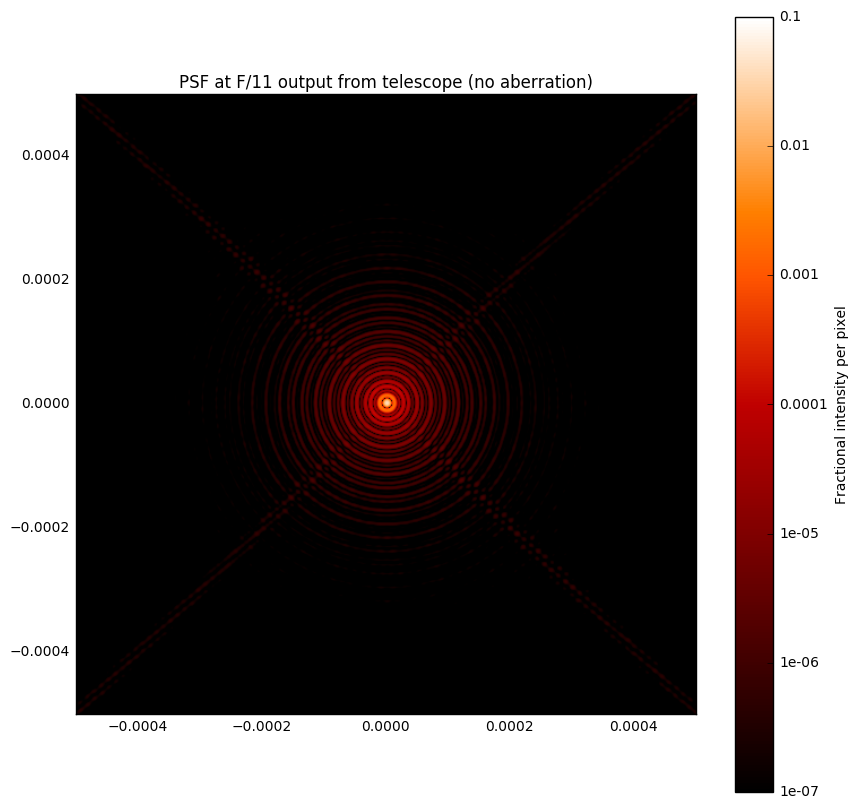

In [12]:
#matplotlib.rcParams["font.size"]=7
#plt.figure(figsize=[17,17])
f11fp_psf = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=False)

# Write to file
f11fp_psf[0].data=np.float32(f11fp_psf[0].data)
#f11fp_psf.writeto('output/PSF/WithoutAberration/f11fp_PSF_WithoutAberration.fits')

# Check out F/11 focal plane PSF
matplotlib.rcParams["font.size"]=10
plt.figure(figsize=[10,10])
poppy.display_PSF(f11fp_psf, imagecrop=0.001)
plt.title("PSF at F/11 output from telescope (no aberration)")

## Part 2: Build to ASM F/16 focal plane.
This is the start of the MagAO-X design.

In [10]:
# Surface: Periscope Mirror 2 (F-2)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-2"), distance=d_f11fp_peri2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-2 aperture"))

# Surface: OAP-0 (O-0)
magaox.add_optic(OAP0, distance=d_peri2_oap0)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-0 aperture"))

# Surface: woofer DM mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="woofer mirror"), distance=d_oap0_woofer)
magaox.add_optic(poppy.CircularAperture(radius=dm_radius, name="woofer mirror aperture"))

# Surface: OAP-1 (O-1)
magaox.add_optic(OAP1, distance=d_woofer_oap1)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-1 aperture"))

# Surface: Fold Mirror 1 (F-3)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-3"), distance=d_oap1_fold1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-3 aperture"))

# Surface: ASM F/16 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="ASM F/16 Focal Plane (uncorrected)"), distance=d_fold1_f16fp)

### Need to calculate correction for F/16 focus point

In [11]:
# Focal plane correction for F/16 ASM
unfixed_f16fp_psf, unfixed_f16fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
f16_last_wave = unfixed_f16fp_wfs[-1]
f16_delta = f16_last_wave.z_w0 - f16_last_wave.z #f16_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/16 ASM PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="ASM F/16 focal plane (corrected)"), distance=f16_delta)

Show F/16 correction:

In [12]:
f16_delta

<Quantity 0.00014376416683958837 m>

### ASM F/16 PSF

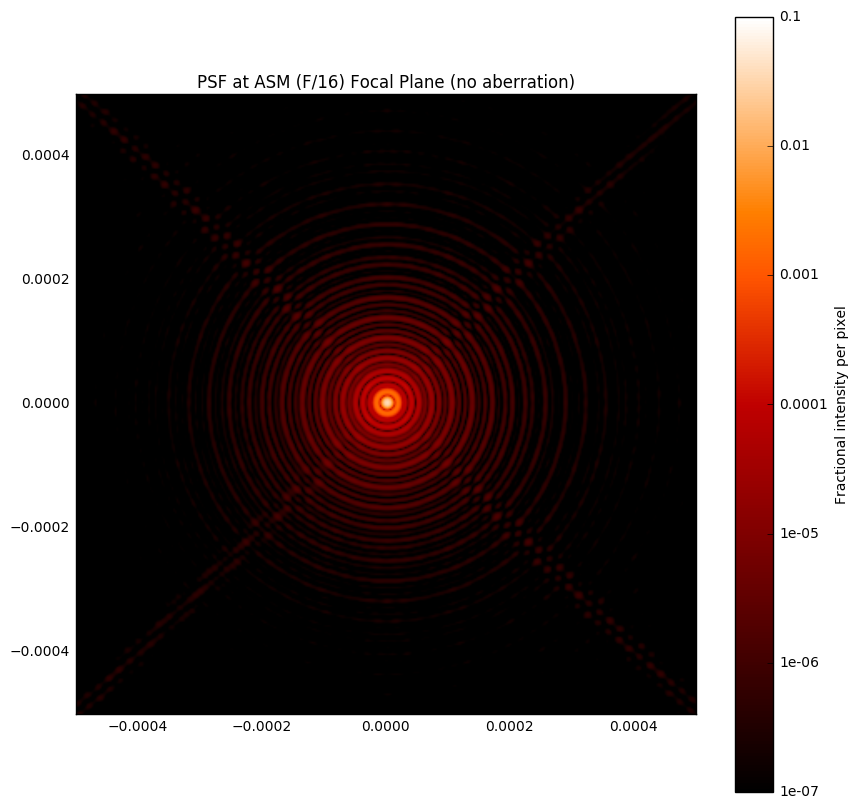

In [16]:
#matplotlib.rcParams["font.size"]=10
#plt.figure(figsize=[20,25])
asm_psf = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=False)

# Write PSF to file
#asm_psf[0].data=np.float32(asm_psf[0].data)
#asm_psf.writeto('output/PSF/WithoutAberration/f16fp_PSF_WithoutAberration.fits')

# Show F/16 focal plane PSF
plt.figure(figsize=[10,10])
poppy.display_PSF(asm_psf, imagecrop=0.001)
plt.title("PSF at ASM (F/16) Focal Plane (no aberration)")

## Part 3: Build to F/57 Focal Plane

In [13]:
# Surface: OAP-2 (O-2)
magaox.add_optic(OAP2, distance=d_f16fp_oap2)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-2 aperture"))

# Surface: tweeter mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="tweeter mirror"), distance=d_oap2_tweeter)
magaox.add_optic(poppy.CircularAperture(radius=dm_radius, name="tweeter mirror aperture"))

# SKIP: ADC, will go from tweeter to OAP-3

# Surface: OAP-3
magaox.add_optic(OAP3, distance=d_tweeter_oap3)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius,name="OAP-3 aperture"))

# Surface: Flat mirror (F-4), Breadboard Mirror 1
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-4"), distance=d_oap3_flat4)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-4 aperture"))

# Surface: Flat mirror (F-5), Breadboard Mirror 5
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-5"), distance=d_flat4_flat5)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-5 aperture"))

# Surface: F/57 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/57 Focal Plane (uncorrected)"), distance=d_flat5_f57fp)

### Need to calculate correction for F/57 focus point

In [14]:
# Focal plane correction for F/57
unfixed_f57fp_psf, unfixed_f57fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
f57_last_wave = unfixed_f57fp_wfs[-1]
f57_delta = f57_last_wave.z_w0 - f57_last_wave.z #f57_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/57 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/57 focal plane (corrected)"), distance=f57_delta)

Show the F/57 correction distance:

In [15]:
f57_delta

<Quantity -0.5549621868642269 m>

Weird number - need to check again with the Zemax sheet

### F/57 PSF
- You can skip running this block if you're not interested in this intermediary focal plane.

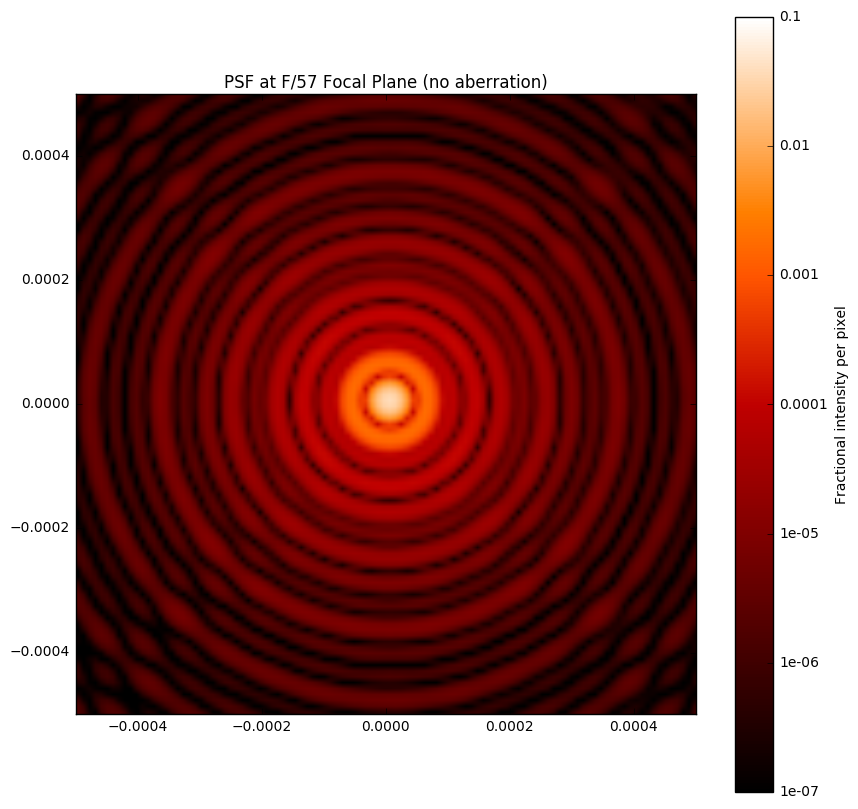

In [20]:
#matplotlib.rcParams["font.size"]=7
#plt.figure(figsize=[25,30])
#f57_psf = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=False)

# Save PSF to file
#f57_psf[0].data=np.float32(f57_psf[0].data)
#f57_psf.writeto('output/PSF/WithoutAberration/f57fp_PSF_WithoutAberration.fits')

# Show PSF
#plt.figure(figsize=[10,10])
#poppy.display_PSF(f57_psf, imagecrop=0.001)
#plt.title("PSF at F/57 Focal Plane (no aberration)")

## Part 4: Build to F/69 Focal Plane

In [21]:
# Surface: OAP-4 (O-4)
magaox.add_optic(OAP4, distance=d_f57fp_oap4)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-4 aperture"))

# Surface: Flat mirror (F-6), Future DM
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-6"), distance=d_oap4_flat6)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-6 aperture"))

# Surface: vAPP coronagraph
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="vAPP"), 
                 distance=d_flat6_vapp)
magaox.add_optic(poppy.CircularAperture(radius=0.009/2 * u.m, name="vAPP mask"))

# Surface: OAP-5 (O-5)
magaox.add_optic(OAP5, distance=d_vapp_oap5)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 aperture"))

# Surface: Fold Mirror 2 (F-7)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-7"), distance=d_oap5_fold2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-7 aperture"))

# Surface: F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Focal Plane (uncorrected)"), distance=d_fold2_f69fp)

### Need to calculate correction for F/69 focus point

In [22]:
# Focal plane correction for F/69
#unfixed_f69fp_psf, unfixed_f69fp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
#f69_last_wave = unfixed_f69fp_wfs[-1]
#f69_delta = f69_last_wave.z_w0 - f69_last_wave.z #f69_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/69 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 focal plane (corrected)"), distance=f69_delta)

Show correction for F/69 focal plane:

In [23]:
f69_delta

<Quantity -2.6626783338201676e-05 m>

### F/69 PSF
- You can skip running this block if you're not interested in this intermediary focal plane.

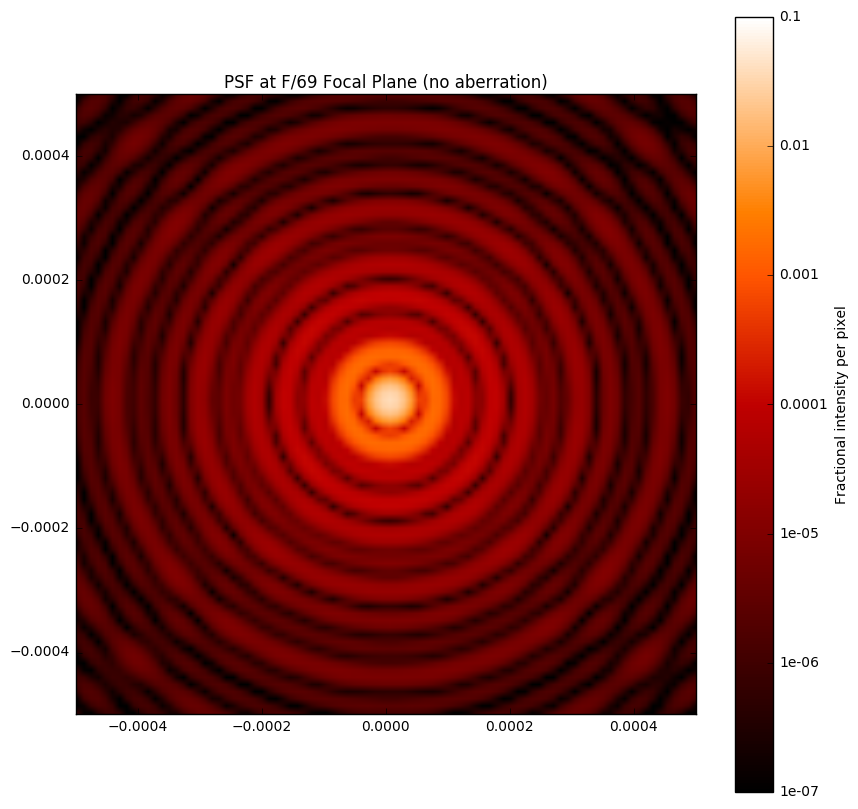

In [24]:
#matplotlib.rcParams["font.size"]=10
#plt.figure(figsize=[28,33])
#f69_psf = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=False)

# Write PSF to file
#f69_psf[0].data=np.float32(f69_psf[0].data)
#f69_psf.writeto('output/PSF/WithoutAberration/f69_PSF_WithoutAberration.fits')

# Show PSF
#plt.figure(figsize=[10,10])
#poppy.display_PSF(f69_psf, imagecrop=0.001)
#plt.title("PSF at F/69 Focal Plane (no aberration)")

## Part 5: Build to Science F/69 Focal Plane

In [25]:
# Surface: OAP-6 (O-6)
magaox.add_optic(OAP6, distance=d_f69fp_oap6)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-6 aperture"))

# Surface: 9mm Lyot Stop
# Removed the Lyot stop aperture, kept the propagation
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="Lyot"), distance=d_oap6_lyot)

# Surface: Fold Mirror 3 (F-11)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-11"), distance=d_lyot_fold3)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-11 aperture"))

# Surface: OAP-7
magaox.add_optic(OAP7, distance=d_fold3_oap7)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-7 aperture"))

# Surface: Fold Mirror 4 (F-12)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F-12"), distance=d_oap7_fold4)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-12 aperture"))

# Surface: Science F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Science Focal Plane (uncorrected)"), distance=d_fold4_f69sci)

### Need to calculate correction for F/69 Science focus point

In [26]:
# Focal plane correction for F/69 Science
unfixed_f69scifp_psf, unfixed_f69scifp_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
f69sci_last_wave = unfixed_f69scifp_wfs[-1]
f69sci_delta = f69sci_last_wave.z_w0 - f69sci_last_wave.z 

# Incorporate the correction distance to see the F/69 PSF.
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Science Focal Plane (corrected)"), distance=f69sci_delta)

Show F/69 Science plane correction:

In [27]:
f69sci_delta

<Quantity -5.1622217284830185e-05 m>

## MagAO-X Optical Element Phase Values

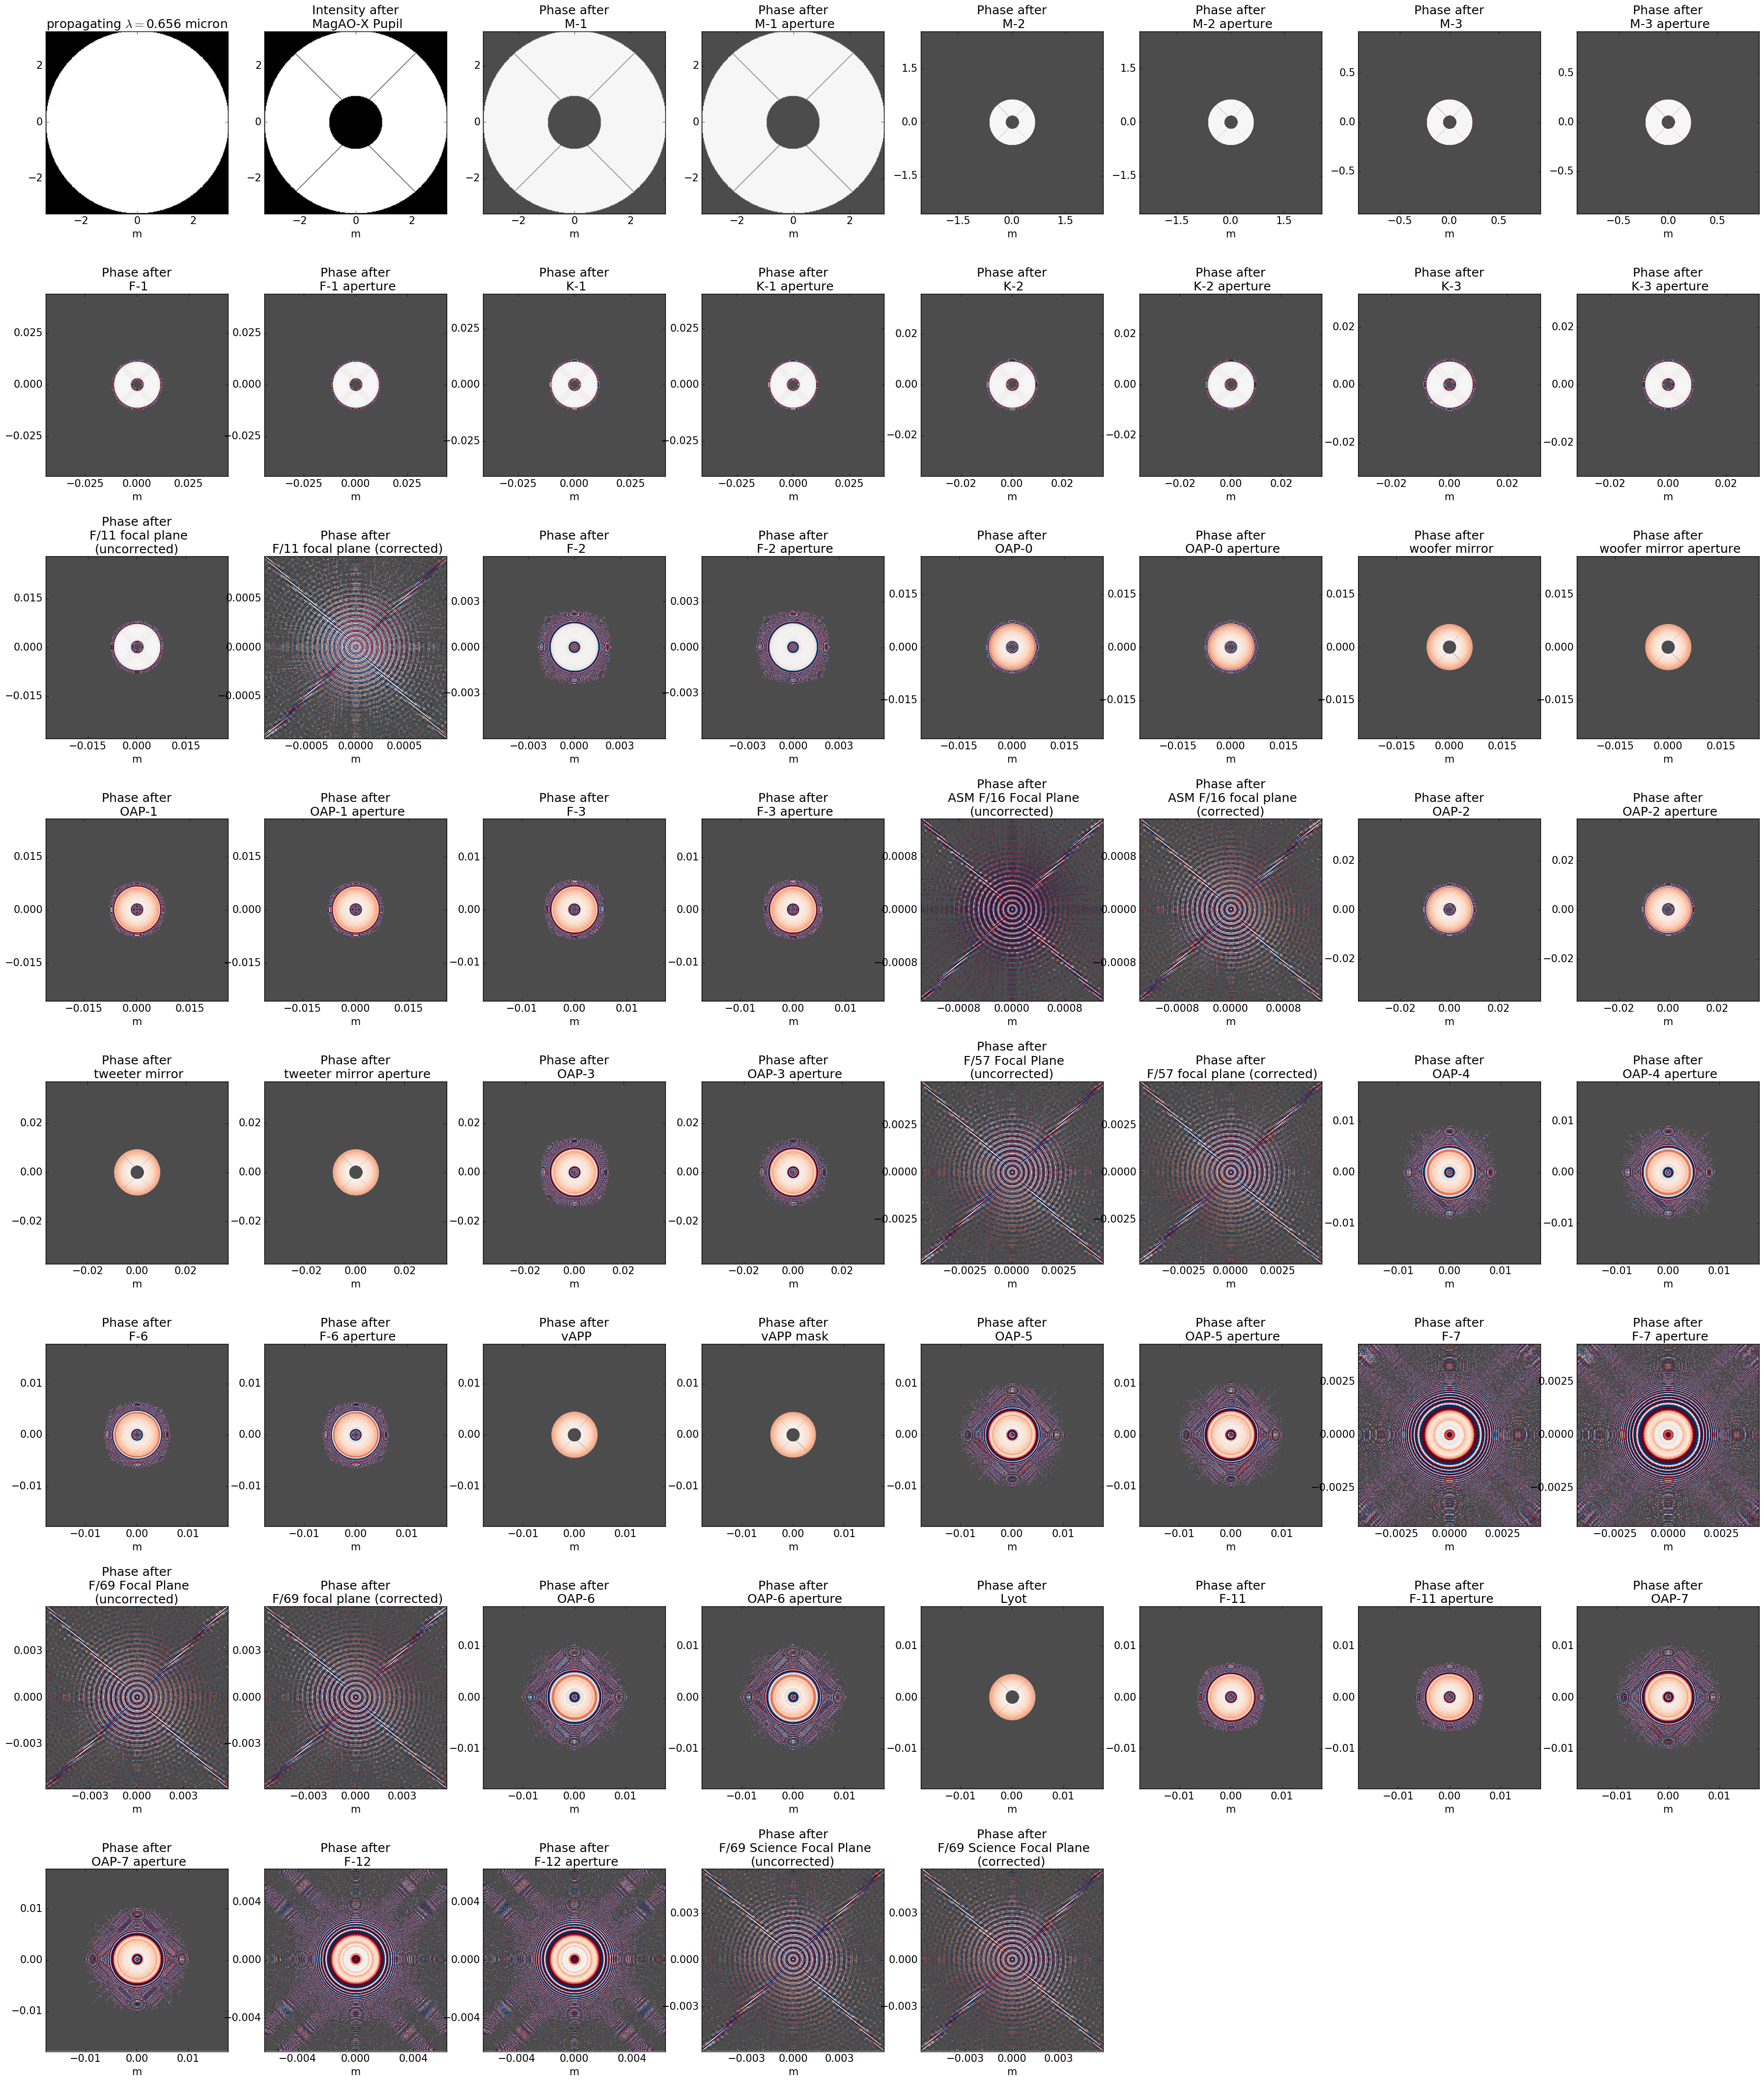

In [29]:
matplotlib.rcParams["font.size"]=15
plt.figure(figsize=[45,54])
f69sci_psf, f69sci_wfs = magaox.calcPSF(wavelength=testWavelength, 
                                        display_intermediates=True, 
                                        return_intermediates=True, 
                                        save_intermediates=False)

## F/69 Science PSF

Show F/69 Science PSF

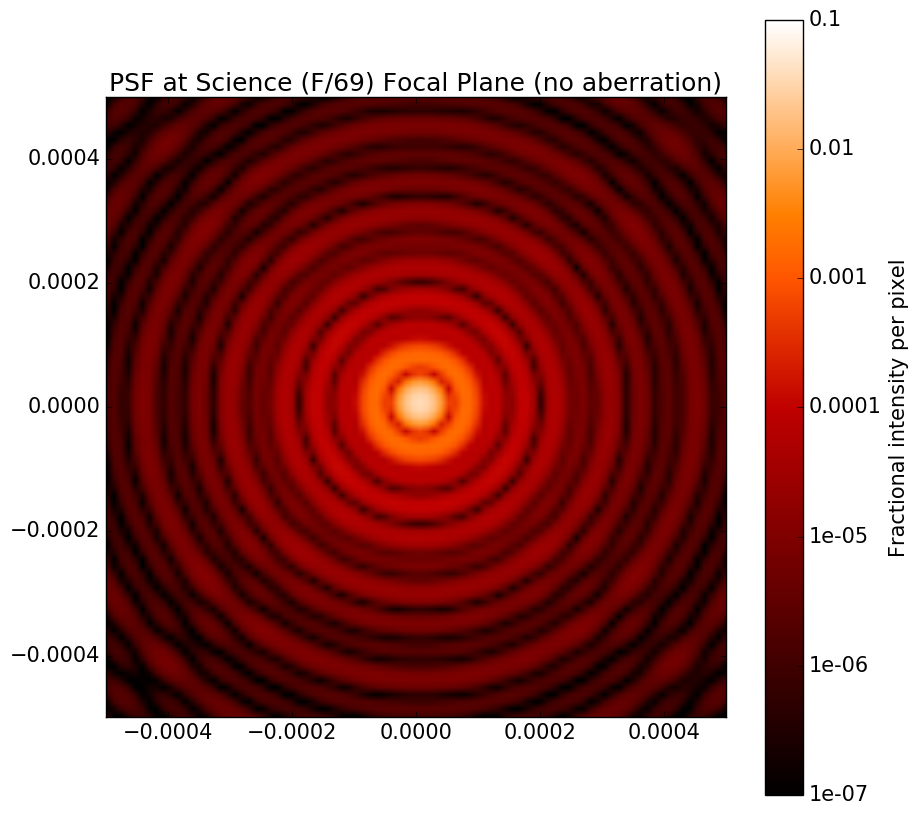

In [30]:
plt.figure(figsize=[10,10])
poppy.display_PSF(f69sci_psf, imagecrop=0.001)
plt.title("PSF at Science (F/69) Focal Plane (no aberration)")